In [1]:
import pyodbc
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### READ DATA 

In [3]:
# conn2 = pyodbc.connect('Driver={SQL Server};'
#                                 'Server=xxxxxx.cahwy5xxx.us-east-1.rds.amazonaws.com,xxxx;'
#                                 'Database=Charity;'
#                                 'uid=xxxxx;pwd=xxxxxxx')
# print ("Connected")
# cursor = conn2.cursor()


In [4]:
# query = '''
#          SELECT *
#          FROM campaign_data
#        '''

# df = pd.read_sql_query(query, con= conn2)

In [5]:
#df.to_csv('campaign data.csv', index = False)

In [6]:
df = pd.read_csv('campaign_data.csv')

In [7]:
df.head(2)

,serial_no,Ad_Group,Search_Keyword,Quality_Score,Ad_relevance_Score,Expected_CTR_Score,Landing_page_exp_Score,Ad_relevance,Expected_CTR,Landing_page_experience,Avg_position,Impressions,Clicks,Total_Cost,Conversions,Revenue_per_unit_sold,Total_Revenue
0,0,Gifts and Banker Products,rorys story cubes,3,0,0.0,1.75,Below average,Below average,Average,7,1935,39,12.90,1,9.99,12.72
1,1,Gifts and Banker Products,gosh christmas frankincense candle,10,2,3.5,3.50,Above average,Above average,Above average,2,28400,1893,189.33,186,25.00,4658.37


In [8]:
df.columns = ['index', 'Ad_Group', 'Search_Keyword', 'Quality_score', 'Ad_relevance_score',
            'Expected_CTR_score', 'Landing_page_exp_score', 'Ad_relevance',
            'Expected_clickthrough_rate', 'Landing_page_experience', 'Avg_position',
             'Impressions', 'Clicks', 'Total_Cost', 'Conversions', 'Revenue_per_unit_sold', 'Total_Revenue']

In [9]:
df = df[['Ad_Group', 'Search_Keyword', 'Quality_score', 'Ad_relevance',
       'Expected_clickthrough_rate', 'Landing_page_experience', 'Ad_relevance_score',
       'Expected_CTR_score', 'Landing_page_exp_score', 'Avg_position', 'Impressions', 'Clicks', 
      'Total_Cost', 'Conversions', 'Revenue_per_unit_sold', 'Total_Revenue']]

### CHANGE AVERAGE POSITION ORDER FROM 1(highest - 10(lowest) TO 10(highest) to 1(lowest)

In [10]:
avg_position = df['Avg_position'].unique()
position_score = [4, 9, 10, 2, 1, 6, 7, 3, 5, 8]
df['position_score'] = df['Avg_position'].map(dict(zip(avg_position, position_score)))

In [11]:
df = df.drop('Avg_position', axis = 1)

In [12]:
df.head(2)

,Ad_Group,Search_Keyword,Quality_score,Ad_relevance,Expected_clickthrough_rate,Landing_page_experience,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,Impressions,Clicks,Total_Cost,Conversions,Revenue_per_unit_sold,Total_Revenue,position_score
0,Gifts and Banker Products,rorys story cubes,3,Below average,Below average,Average,0,0.0,1.75,1935,39,12.90,1,9.99,12.72,4
1,Gifts and Banker Products,gosh christmas frankincense candle,10,Above average,Above average,Above average,2,3.5,3.50,28400,1893,189.33,186,25.00,4658.37,9


### SPLIT DATA TO TRAINING AND TEST DATA FOR MODELING

In [13]:
features = list(df.columns.drop('Conversions'))

X = df[features]
y = df['Conversions']

In [14]:
from sklearn.model_selection import train_test_split
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= SEED)

In [15]:
training_df = pd.concat([X_train, y_train], axis = 1)

test_df = pd.concat([X_test, y_test], axis = 1)

### Effect of Factors Affecting Quality Score

#### Pearson correlation matrix of Quality Score and its Factors

In [16]:
df_qs = df[['Quality_score', 'Ad_relevance_score',
       'Expected_CTR_score', 'Landing_page_exp_score']]

<AxesSubplot:>

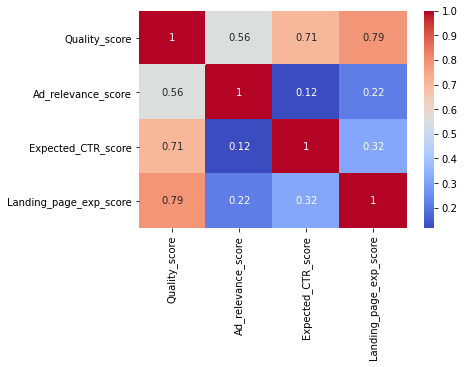

In [17]:
sns.heatmap(df_qs.corr(), annot = True, cmap = 'coolwarm')

In [18]:
from statsmodels.formula.api import ols

model = ols('Quality_score ~ Ad_relevance_score + Expected_CTR_score +\
                    Landing_page_exp_score + 0', data = training_df).fit()

In [19]:
print(f"{model.params} \n") 
print(f"rsquared: {model.rsquared}")

Ad_relevance_score        1.273957
Expected_CTR_score        1.419437
Landing_page_exp_score    0.902590
dtype: float64 

rsquared: 0.9900136293076974


### Effect of Quality score on Average Ad position

In [20]:
model2 = ols('position_score ~ Quality_score + 0', data = training_df).fit()

In [21]:
print(f"{model2.params} \n") 
print(f"rsquared: {model2.rsquared}")

Quality_score    0.99755
dtype: float64 

rsquared: 0.8602117028958625


### Effect of Average position on Impressions

In [22]:
model3 = ols('Impressions ~ Ad_Group:position_score + 0', data = training_df).fit()

In [23]:
print(f"{model3.params} \n") 
print(f"rsquared: {model3.rsquared}")

Ad_Group[Alternative Gifts]:position_score            1908.181416
Ad_Group[Books]:position_score                        2975.863636
Ad_Group[Children's Clothes]:position_score           1288.330097
Ad_Group[Christmas Cards]:position_score              1034.415205
Ad_Group[Gifts and Banker Products]:position_score    1998.605373
Ad_Group[Marketing]:position_score                    3472.000000
dtype: float64 

rsquared: 0.7413736872336099


### Effect of Impressions on Clicks

In [24]:
model4 = ols('Clicks ~ Ad_Group:Impressions + 0', data = training_df).fit()

In [25]:
print(f"{model4.params} \n") 
print(f"rsquared: {model4.rsquared}")

Ad_Group[Alternative Gifts]:Impressions            0.046675
Ad_Group[Books]:Impressions                        0.039186
Ad_Group[Children's Clothes]:Impressions           0.033180
Ad_Group[Christmas Cards]:Impressions              0.033635
Ad_Group[Gifts and Banker Products]:Impressions    0.055237
Ad_Group[Marketing]:Impressions                    0.026642
dtype: float64 

rsquared: 0.9651159113833189


### Effect of Clicks on Conversions

In [26]:
model5 = ols('Conversions ~ Ad_Group:Clicks + 0', data = training_df).fit()

In [27]:
print(f"{model5.params} \n") 
print(f"rsquared: {model5.rsquared}")

Ad_Group[Alternative Gifts]:Clicks            0.070112
Ad_Group[Books]:Clicks                        0.060380
Ad_Group[Children's Clothes]:Clicks           0.049703
Ad_Group[Christmas Cards]:Clicks              0.054839
Ad_Group[Gifts and Banker Products]:Clicks    0.088262
Ad_Group[Marketing]:Clicks                    0.037838
dtype: float64 

rsquared: 0.9777787508691803


### Chisquare Test of Independence between Ad Groups and Landing Page experince

In [28]:
df['Ad_Group'].unique()

array(['Gifts and Banker Products', 'Marketing', "Children's Clothes",
       'Books', 'Christmas Cards', 'Alternative Gifts'], dtype=object)

In [29]:
ad_group_relevance = df.groupby('Ad_Group')['Landing_page_experience'].value_counts(normalize = True).unstack()
ad_group_relevance

Landing_page_experience,Above average,Average,Below average
Ad_Group,,,
Alternative Gifts,NaN,0.500000,0.500000
Books,NaN,0.571429,0.428571
Children's Clothes,NaN,0.200000,0.800000
Christmas Cards,NaN,0.048387,0.951613
Gifts and Banker Products,0.298507,0.208955,0.492537
Marketing,NaN,NaN,1.000000


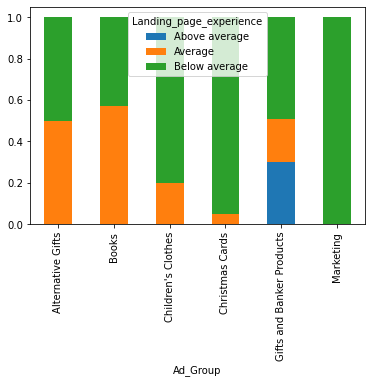

In [30]:
ad_group_relevance.plot(kind='bar', stacked=True) 
plt.show()

In [31]:
import pingouin

In [32]:
expected, observed, stat = pingouin.chi2_independence(data = df, x = 'Ad_Group', y = 'Landing_page_experience')

C:\Users\tuneG\anaconda3\lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\tuneG\anaconda3\lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\tuneG\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:6775: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\tuneG\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:6775: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\tuneG\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:6772: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


In [33]:
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,50.379197,10.0,2.272914e-07,0.415369,0.957056
1,cressie-read,0.666667,50.295546,10.0,2.354963e-07,0.415024,0.956712
2,log-likelihood,0.000000,56.272902,10.0,1.824876e-08,0.438994,0.975902
3,freeman-tukey,-0.500000,NaN,10.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000000,inf,10.0,0.000000e+00,inf,1.000000
5,neyman,-2.000000,NaN,10.0,NaN,NaN,NaN


### Predicting Ads Keyword Conversions

#### Preprocessing

In [34]:
training_df.head(3)

,Ad_Group,Search_Keyword,Quality_score,Ad_relevance,Expected_clickthrough_rate,Landing_page_experience,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,Impressions,Clicks,Total_Cost,Revenue_per_unit_sold,Total_Revenue,position_score,Conversions
124,Christmas Cards,ho ho ho santa christmas card,5,Above average,Average,Below average,2,1.75,0.0,10825,361,72.17,3.00,54.86,7,18
51,Gifts and Banker Products,posting christmas stocking gift bag large,7,Average,Average,Above average,1,1.75,3.5,24206,1130,161.37,1.40,110.06,9,79
42,Gifts and Banker Products,love life amazing dad keyring,3,Below average,Average,Below average,0,1.75,0.0,1764,35,11.76,2.99,3.27,3,1


In [35]:
training_df = training_df[['Ad_Group', 'Quality_score',  'Ad_relevance_score', 'Expected_CTR_score', 'Landing_page_exp_score',
          'position_score', 'Impressions', 'Clicks', 'Conversions']]

test_df = test_df[['Ad_Group', 'Quality_score',  'Ad_relevance_score', 'Expected_CTR_score', 'Landing_page_exp_score',
          'position_score', 'Impressions', 'Clicks', 'Conversions']]


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE

In [37]:
cat_columns = ['Ad_Group']

In [38]:
def one_hot_encoding(training_df):
    from sklearn.preprocessing import OneHotEncoder
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
    ohe.fit(training_df[cat_columns])
    
    cat_ohe = ohe.transform(training_df[cat_columns])
    ohe_training_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = cat_columns))

    training_df.reset_index(inplace= True)
    training_df.drop('index', axis= 1, inplace= True)

    training_df_encoded = pd.concat([training_df, ohe_training_df], axis=1).drop(columns = cat_columns, axis=1)
    
    return ohe, training_df_encoded

In [39]:
encoder, training_df_encoded =  one_hot_encoding(training_df)
#pickle.dump(encoder, open('Fitted_OneHotencoder.pkl', 'wb'))

def encode_new_data(new_data_df):
    cat_ohe_new = encoder.transform(new_data_df[cat_columns])
    ohe_new_data_df = pd.DataFrame(cat_ohe_new, columns = encoder.get_feature_names_out(input_features = cat_columns))
    
    new_data_df.reset_index(inplace= True)
    new_data_df.drop('index', axis= 1, inplace= True)
    
    new_data_df_encoded = pd.concat([new_data_df, ohe_new_data_df], axis=1).drop(columns = cat_columns, axis=1)
    return new_data_df_encoded



C:\Users\tuneG\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tuneG\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [40]:
test_df_encoded = encode_new_data(test_df)

In [41]:
features = list(training_df_encoded.columns.drop('Conversions'))

X_train = training_df_encoded[features]
y_train = training_df_encoded['Conversions']

X_test = test_df_encoded[features]
y_test = test_df_encoded['Conversions']

#### Fitting and Evaluating Linear Regression Model

In [42]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)

In [43]:
y_pred = model.predict(X_test)

In [44]:
MAE(y_test, y_pred)

1.7861312060233763

### Sample Tweaking of 'Quality Score' factor(s) (Expected_CTR_score) to see the effect on Conversions

In [45]:
X_test.loc[26,:]

Quality_score                             7.00
Ad_relevance_score                        2.00
Expected_CTR_score                        1.75
Landing_page_exp_score                    1.75
position_score                            8.00
Impressions                           15533.00
Clicks                                  725.00
Ad_Group_Alternative Gifts                1.00
Ad_Group_Books                            0.00
Ad_Group_Children's Clothes               0.00
Ad_Group_Christmas Cards                  0.00
Ad_Group_Gifts and Banker Products        0.00
Ad_Group_Marketing                        0.00
Name: 26, dtype: float64

In [46]:
print(f"Current Conversions for Ad_keyword above: {y_test.loc[26]}")

Current Conversions for Ad_keyword above: 51


Increased the Expected_CTR_score by one unit to 3.5

In [47]:
dataa = {'Quality_score': [8], 'Ad_relevance_score':[2], 'Expected_CTR_score':[3.5],
       'Landing_page_exp_score': [1.75], 'position_score':[9], 'Impressions':[17448], 'Clicks':[814],
       'Ad_Group_Alternative Gifts': [1], 'Ad_Group_Books': [0],
       "Ad_Group_Children's Clothes":[0], 'Ad_Group_Christmas Cards':[0],
       'Ad_Group_Gifts and Banker Products':[0], 'Ad_Group_Marketing':[0]}

In [48]:
new_data = pd.DataFrame(dataa)

In [49]:
new_data

,Quality_score,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,position_score,Impressions,Clicks,Ad_Group_Alternative Gifts,Ad_Group_Books,Ad_Group_Children's Clothes,Ad_Group_Christmas Cards,Ad_Group_Gifts and Banker Products,Ad_Group_Marketing
0,8,2,3.5,1.75,9,17448,814,1,0,0,0,0,0


In [50]:
print(f"New Conversions count after increasing Expected_CTR_score of keyword: {model.predict(new_data)[0]}")

New Conversions count after increasing Expected_CTR_score of keyword: 54.37528644478394


### AUTOMATING QUALITY SCORE FACTOR(S) TWEAKS

#### USING RESULTING QUALITY SCORE, AVERAGE POSITION SCORE, NUMBER OF IMPRESSIONS AND CLICKS
#### TO _PREDICT NUMBER OF CONVERSIONS_    

### FUNCTION TO CHANGE QUALITY SCORE BY IMPROVING ONE OR MORE FACTOR

In [51]:
def change_Qualityscore(row, factor = None, change = None):
    model = ols('Quality_score ~ Ad_relevance_score + Expected_CTR_score +\
                        Landing_page_exp_score + 0', data = df).fit()
    qs = row['Quality_score']
    if factor == 'Ad_relevance':
        if change == 'improve':
            if qs < 10:
                qs += model.params['Ad_relevance_score']
                return round(qs)
            else:
                return qs
        elif change == 'recede':
            if qs > 0:
                qs -= model.params['Ad_relevance_score']
                return round(qs)
            else:
                return qs
        
    elif factor == 'Expected_clickthrough_rate':
        if change == 'improve':
            if qs < 10:
                qs += model.params['Expected_CTR_score']
                return round(qs)
            else:
                return qs
        elif change == 'recede':
            if qs > 0:
                qs -= model.params['Expected_CTR_score']
                return round(qs)
            else:
                return qs
        
    elif factor == 'Landing_page_experience':
        if change == 'improve':
            if qs < 10:
                qs += model.params['Landing_page_exp_score']
                return round(qs)
            else:
                return qs
        elif change == 'recede':
            if qs > 0:
                qs -= model.params['Landing_page_exp_score']
                return round(qs)
            else:
                return qs
    
    else:
        return qs

In [52]:
change_Qualityscore(X_test.loc[0,:] ,'Landing_page_experience', 'improve')

4

### FUNCTION TO IMPROVE OR RECEDE AVERAGE AD POSITION

In [53]:
def change_ADposition(row, factor, change):
    
    current_qs = row['Quality_score']
    current_position = row['position_score'] 
    new_qs = change_Qualityscore(row, factor, change)
    model2 = ols('position_score ~ Quality_score + 0', data = df).fit()
    
    if new_qs > current_qs:
        if current_position < 10:
            current_position += model2.params['Quality_score']
            return round(current_position)
        else:
            return current_position
    
    elif new_qs < current_qs:
        if current_position > 0:
            current_position -= model2.params['Quality_score']
            return round(current_position)
        else:
            return current_position
    
    elif new_qs == current_qs:
        return current_position

In [54]:
change_ADposition(X_test.loc[0,:], 'Landing_page_experience', 'improve')

4

### FUNCTION TO CHANGE IMPRESSIONS

In [55]:
def change_Impressions(row, ad_group, factor, change_type):
    model3 = ols('Impressions ~ Ad_Group:position_score + 0', data = df).fit()
    
    current_position = row['position_score']
    new_position = change_ADposition(row, factor, change_type)
    impressions = row['Impressions']
    if ad_group == 'Alternative Gifts':
        if new_position > current_position:
            impressions += model3.params['Ad_Group[Alternative Gifts]:position_score']
            return round(impressions)
        elif new_position > current_position:
            impressions -= model3.params['Ad_Group[Alternative Gifts]:position_score']
            return round(impressions)
        elif new_position == current_position:
            return impressions

        
    elif ad_group == 'Books':
        if new_position > current_position:
            impressions += model3.params['Ad_Group[Books]:position_score']
            return round(impressions)
        elif new_position > current_position:
            impressions -= model3.params['Ad_Group[Books]:position_score']
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Children's Clothes":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Children's Clothes]:position_score"]
            return round(impressions)
        elif new_position > current_position:
            impressions -= model3.params["Ad_Group[Children's Clothes]:position_score"]
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Christmas Cards":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Christmas Cards]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Christmas Cards]:position_score"]
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Gifts and Banker Products":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Gifts and Banker Products]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Gifts and Banker Products]:position_score"]
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Marketing":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Marketing]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Marketing]:position_score"]
            return round(impressions)
    elif new_position == current_position:
            return impressions
        
        
    


In [56]:
change_Impressions(X_test.loc[0,:], 'Christmas Cards', 'Landing_page_experience', 'improve')

1998

### FUNCTION TO CHANGE CLICKS

In [57]:
def change_Clicks(row, ad_group, factor, change_type):
    model4 = ols('Clicks ~ Ad_Group:Impressions + 0', data = df).fit()
    
    current_clicks = row['Clicks']
    current_impressions = row['Impressions']
    new_impressions = change_Impressions(row, ad_group, factor, change_type)
    impressions_change = new_impressions - current_impressions
    
    if ad_group == 'Alternative Gifts':
        if new_impressions > current_impressions:
            clicks = current_clicks + impressions_change * model4.params['Ad_Group[Alternative Gifts]:Impressions']
            return round(clicks)
        elif new_impressions < current_impressions:
            clicks = current_clicks - impressions_change * model4.params['Ad_Group[Alternative Gifts]:Impressions']
            return round(clicks)
        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
    elif ad_group == 'Books':
        if new_impressions > current_impressions:
            clicks = current_clicks + current_impressions * model4.params['Ad_Group[Books]:Impressions']
            return round(clicks)
        elif new_impressions < current_impressions:
            clicks = current_clicks - current_impressions * model4.params['Ad_Group[Books]:Impressions']
            return round(clicks)
        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
    elif ad_group == "Children's Clothes":
        if new_impressions > current_impressions:
            clicks = current_clicks + impressions_change  * model4.params["Ad_Group[Children's Clothes]:Impressions"]
            return round(clicks)
        elif new_impressions > current_impressions:
            clicks = current_clicks - impressions_change  * model4.params["Ad_Group[Children's Clothes]:Impressions"]
            return round(clicks)
        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
        
    elif ad_group == "Christmas Cards":
        if new_impressions > current_impressions:
            clicks = current_clicks + impressions_change * model4.params["Ad_Group[Christmas Cards]:Impressions"]
            return round(clicks)
        elif new_impressions > current_impressions:
            clicks = current_clicks - impressions_change * model4.params["Ad_Group[Christmas Cards]:Impressions"]
            return round(clicks)
        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
    elif ad_group == "Gifts and Banker Products":
        if new_impressions > current_impressions:
            clicks = current_clicks + impressions_change * model4.params["Ad_Group[Gifts and Banker Products]:Impressions"]
            return round(clicks)
        elif new_impressions < current_impressions:
            clicks = current_clicks - impressions_change * model4.params["Ad_Group[Gifts and Banker Products]:Impressions"]
            return round(clicks)
        elif new_impressions == current_impressions:
            return round(current_clicks)
        
    elif ad_group == "Marketing":
        if new_impressions > current_impressions:
            clicks =  current_clicks + impressions_change * model4.params["Ad_Group[Marketing]:Impressions"]
            return round(clicks)
        elif new_impressions < current_impressions:
            clicks = current_clicks - impressions_change * model4.params["Ad_Group[Marketing]:Impressions"]
        elif new_impressions == current_impressions:
            return round(current_clicks)

In [58]:
change_Clicks(X_test.loc[0,:], 'Christmas Cards', 'Landing_page_experience', 'improve')

53

In [59]:
class changeQs:
    
    def __init__(self, current_row):
        self.current_row = current_row
    
    def change_one_factor(self, change_factor, change_type, ad_group):
        if change_type == 'improve':
            new_row = {'Quality_score': change_Qualityscore(self.current_row , change_factor, change_type),
                       'Ad_relevance_score': [self.current_row['Ad_relevance_score'] + 1 if change_factor == 'Ad_relevance' and\
                                              self.current_row['Ad_relevance_score'] < 2 else self.current_row['Ad_relevance_score']][0],
                       'Expected_CTR_score': [self.current_row['Expected_CTR_score'] + 1.75 if change_factor == 'Expected_clickthrough_rate' and\
                                              self.current_row['Expected_CTR_score'] < 3.5 else self.current_row['Expected_CTR_score']][0],
                       'Landing_page_exp_score': [self.current_row['Landing_page_exp_score'] + 1.75 if change_factor == 'Landing_page_experience' and\
                                                  self.current_row['Landing_page_exp_score'] < 3.5 else self.current_row['Landing_page_exp_score']][0],
                       'position_score': change_ADposition(self.current_row, change_factor, change_type), 
                       'Impressions': change_Impressions(self.current_row, ad_group, change_factor, change_type),
                       'Clicks': change_Clicks(self.current_row, ad_group, change_factor, change_type),
                       'Ad_Group_Alternative Gifts':self.current_row['Ad_Group_Alternative Gifts'],
                       'Ad_Group_Books': self.current_row['Ad_Group_Books'],
                       "Ad_Group_Children's Clothes": self.current_row["Ad_Group_Children's Clothes"],
                       'Ad_Group_Christmas Cards': self.current_row["Ad_Group_Christmas Cards"],
                       'Ad_Group_Gifts and Banker Products': self.current_row['Ad_Group_Gifts and Banker Products'],
                       'Ad_Group_Marketing': self.current_row['Ad_Group_Marketing']}

        elif change_type =='recede':
                 new_row = {'Quality_score': change_Qualityscore(self.current_row , change_factor, change_type),
                       'Ad_relevance_score': [self.current_row['Ad_relevance_score'] - 1 if change_factor == 'Ad_relevance' and\
                                              self.current_row['Ad_relevance_score'] != 0 else self.current_row['Ad_relevance_score']][0],
                    'Expected_CTR_score': [self.current_row['Expected_CTR_score'] - 1.75 if change_factor == 'Expected_clickthrough_rate' and\
                                         self.current_row['Expected_CTR_score'] != 0 else self.current_row['Expected_CTR_score']][0],
                       'Landing_page_exp_score': [self.current_row['Landing_page_exp_score'] - 1.75 if change_factor == 'Landing_page_experience' and\
                                                  self.current_row['Landing_page_exp_score'] != 0 else self.current_row['Landing_page_exp_score']][0],
                       'position_score': change_ADposition(self.current_row, change_type), 
                       'Impressions': change_Impressions(self.current_row, ad_group, change_factor, change_type),
                       'Clicks': change_Clicks(self.current_row, ad_group, change_factor, change_type),
                       'Ad_Group_Alternative Gifts':self.current_row['Ad_Group_Alternative Gifts'],
                       'Ad_Group_Books': self.current_row['Ad_Group_Books'],
                       "Ad_Group_Children's Clothes": self.current_row["Ad_Group_Children's Clothes"],
                       'Ad_Group_Christmas Cards': self.current_row["Ad_Group_Christmas Cards"],
                       'Ad_Group_Gifts and Banker Products': self.current_row['Ad_Group_Gifts and Banker Products'],
                       'Ad_Group_Marketing': self.current_row['Ad_Group_Marketing']}
        self.current_row = new_row
        return self.current_row

In [60]:
X_test.loc[0,:]

Quality_score                           3.00
Ad_relevance_score                      0.00
Expected_CTR_score                      1.75
Landing_page_exp_score                  0.00
position_score                          3.00
Impressions                           963.00
Clicks                                 19.00
Ad_Group_Alternative Gifts              0.00
Ad_Group_Books                          0.00
Ad_Group_Children's Clothes             0.00
Ad_Group_Christmas Cards                1.00
Ad_Group_Gifts and Banker Products      0.00
Ad_Group_Marketing                      0.00
Name: 0, dtype: float64

In [61]:
data = changeQs(X_test.loc[0,:])

In [62]:
new_data = data.change_one_factor('Landing_page_experience', 'improve', 'Christmas Cards')
new_data

{'Quality_score': 4,
 'Ad_relevance_score': 0.0,
 'Expected_CTR_score': 1.75,
 'Landing_page_exp_score': 1.75,
 'position_score': 4,
 'Impressions': 1998,
 'Clicks': 53,
 'Ad_Group_Alternative Gifts': 0.0,
 'Ad_Group_Books': 0.0,
 "Ad_Group_Children's Clothes": 0.0,
 'Ad_Group_Christmas Cards': 1.0,
 'Ad_Group_Gifts and Banker Products': 0.0,
 'Ad_Group_Marketing': 0.0}

In [63]:
# new_data = data.change_one_factor('Landing_page_experience', 'improve', 'Alternative Gifts')
# new_data

In [64]:
# new_X = pd.DataFrame({k: [v] for k,v in new_data.items()})

In [65]:
# y_pred = model.predict(new_X)

In [66]:
# y_pred

In [67]:
def get_adgroup(row):
    cols = ['Ad_Group_Alternative Gifts', 'Ad_Group_Books',
       "Ad_Group_Children's Clothes", 'Ad_Group_Christmas Cards',
       'Ad_Group_Gifts and Banker Products', 'Ad_Group_Marketing']
    
    for col in cols:
        if row[col] == 1:
            return col.split('_',2)[-1]

In [68]:
#get_adgroup(X_test.loc[29,:])

In [69]:
X_test[['Quality_score', 'Ad_relevance_score', 'Expected_CTR_score',
       'Landing_page_exp_score', 'position_score', 'Impressions', 'Clicks']].tail()

,Quality_score,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,position_score,Impressions,Clicks
25,6,1,1.75,1.75,7,11808,472
26,7,2,1.75,1.75,8,15533,725
27,4,1,1.75,0.00,1,6080,162
28,3,0,1.75,0.00,4,3465,69
29,9,1,3.50,3.50,10,17253,1035


In [70]:
dicts_list = []
for idx, row in X_test.iterrows():
    data = changeQs(row)
    ad_group = get_adgroup(row)
    data.change_one_factor('Landing_page_experience', 'improve', ad_group)
    new_data = data.change_one_factor('Expected_clickthrough_rate', 'improve', ad_group)
    dicts_list.append(new_data)

In [71]:
new_X = pd.DataFrame(dicts_list)
#[['Quality_score', 'Ad_relevance_score', 'Expected_CTR_score',
 #      'Landing_page_exp_score', 'position_score', 'Impressions', 'Clicks']]
new_X.tail()

,Quality_score,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,position_score,Impressions,Clicks,Ad_Group_Alternative Gifts,Ad_Group_Books,Ad_Group_Children's Clothes,Ad_Group_Christmas Cards,Ad_Group_Gifts and Banker Products,Ad_Group_Marketing
25,8.0,1.0,3.5,3.50,9.0,15952.0,710,0.0,0.0,0.0,0.0,1.0,0.0
26,9.0,2.0,3.5,3.50,10.0,19365.0,903,1.0,0.0,0.0,0.0,0.0,0.0
27,6.0,1.0,3.5,1.75,3.0,8150.0,230,0.0,0.0,0.0,1.0,0.0,0.0
28,5.0,0.0,3.5,1.75,6.0,5535.0,137,0.0,0.0,0.0,1.0,0.0,0.0
29,10.0,1.0,3.5,3.50,10.0,17253.0,1035,0.0,0.0,0.0,0.0,1.0,0.0


In [72]:
y_pred = model.predict(new_X)

In [73]:
y_pred

array([  0.3248616 , 240.42877602,  28.17366778,  27.86774501,
         2.20135504, 189.25940873,   1.75522443,   5.45179636,
        20.03311094,  23.65064657,  26.15602031,  32.13554168,
        -0.95733901, 293.03709257,  -2.11703966,  15.3042901 ,
        13.38993269,   4.77472289,   8.76993468,  16.46519606,
        46.87346402,  -2.21079449,  29.91574127,   1.89636586,
        38.6786412 ,  44.51600657,  57.77427215,   2.08462018,
        -2.20610795,  95.42614665])

In [74]:
test_df['Conversions']

0       1
1     245
2      27
3      20
4       8
5     185
6       7
7       6
8      10
9       7
10      4
11     13
12      1
13    300
14      2
15      0
16     17
17      0
18     11
19      0
20     28
21      2
22     15
23      4
24     22
25     29
26     51
27      6
28      2
29     94
Name: Conversions, dtype: int64

In [75]:
new_clicks = new_X[['Quality_score', 'Ad_relevance_score', 'Expected_CTR_score',
       'Landing_page_exp_score', 'position_score', 'Impressions', 'Clicks']]['Clicks']

In [76]:
dff = pd.concat([test_df['Conversions'], round(pd.DataFrame(y_pred))], axis = 1)

In [77]:
dff.columns = ['old_conversions', 'new_conversions']

In [78]:
pingouin.ttest(x = dff['new_conversions'], y= dff['old_conversions'], paired = True, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.735487,29,greater,0.005258,"[1.78, inf]",0.064388,8.632,0.096742
